In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import os 
from model.SimCLR import SimCLR
from model.Train import Trainer
from model.Losses import NTXentLoss
from utils.DataLoaderSimCLR import DataLoaderSimCLR as DSC
from utils.DataLoaderTest import DataLoaderTest as DLT
from torch.utils.data import DataLoader, random_split
from utils.Similarity import Similarity as SMY
from utils.Plotter import Plotter as PL

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\halim\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\halim\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
torch.cuda.empty_cache()

In [4]:
SSH = os.getcwd() != 'c:\\Cours-Sorbonne\\M1\\Stage\\src'

In [5]:
path_rol_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_compressed" 
path_rol_super_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_super_compressed" 
path_rol_ht_super_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_ht_super_compressed" 
path_sim_rol_extracted_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/similaires_rol_extracted_nn_compressed" 
path_filtered = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_compressed/json_filtered"
path_targets = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_sim_rol_triplets/targets.npy"
bad_pairs_path = "C:/Cours-Sorbonne/M1/Stage/src/files/bad_pairs.txt"
to_enhance_path = "C:/Cours-Sorbonne/M1/Stage/src/files/to_enhance_pairs.txt"
path_sim_rol_test = "C:/Cours-Sorbonne/M1/Stage/src/data/data_PPTI/sim_rol_test"

if SSH:
    path_rol_ht_super_comp = "../data/rol_ht_super_compressed" 
    path_rol_comp = "../data/rol_super_compressed" 
    path_sim_rol_extracted_comp = "../data/sim_rol_super_compressed" 
    path_filtered = "../data/rol_super_compressed/json_filtered"
    path_sim_rol_test = "../data/sim_rol_test"
    path_targets = "../data/rol_sim_rol_couples/targets.npy"
    bad_pairs_path = "./files/bad_pairs.txt"
    to_enhance_path = "./files/to_enhance_pairs.txt"

## Params

In [6]:
epochs = 50
image_size = 256
batch_size = 32
learning_rate = 1e-3
train_ratio = 0.8
val_ratio = 0.2
temperature = 0.5

In [7]:
dataset = DSC(
    path_rol_comp, path_sim_rol_extracted_comp, path_filtered,
    shape=(image_size, image_size), target_path=path_targets,
    to_enhance_path=to_enhance_path, bad_pairs_path=bad_pairs_path,
    path_sim_rol_test=path_sim_rol_test, max_images=40000,
    augment_test=False, use_only_rol=True, use_context=True, remove_to_enhance_files=True, remove_bad_pairs=True
)

train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

[INFO] Using ROL Dataset with 39757 images
[INFO] Loaded exsisting targets


In [8]:
DSC.show_data(train_loader,1,use_context=False)
DSC.show_data(val_loader,1,use_context=False)

a group of men riding horses in a field
in group of men riding horses a a theater
a black and white photo of a dog and a cat
of shameful and white photo a a dog and a cat
a man in a car with another man in the back
a man in IN a car with another homo in the back
a man riding a bicycle in front of a crowd
a man gentleman razz a bicycle in front of a crowd
a black and white photo of a man in a suit
a a and Caucasian photo of black man in a suit
a group of people are standing in the snow
in group of people are resist a the snow
a black and white photo of a building
a black and white pic of a 
a group of men posing for a photo
a group of humanity posing for a picture
a statue in a park with a horse on top
a statue in a park with a knight on amp top
an old photo of a man with a beard and a top hat
an old photo of a world with beard and a top hat
a man in a white suit and hat standing in front of a building
a man in a white suit and hat abide in front of a building
a man riding a bike on a d

ValueError: too many values to unpack (expected 2)

# Approche Supervisé

In [8]:
model = SimCLR(feature_size=128, use_context=True, context_weights=1.0)
optimizer = torch.optim.AdamW
loss_fn = NTXentLoss(temperature=temperature)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
trainer = Trainer()
trainer.set_model(model, "SimCLR-128") \
.set_optimizer(optimizer) \
.set_loss(loss_fn) 

model = trainer.fit(
    train_data=train_loader, validation_data=val_loader, learning_rate=learning_rate, 
    verbose=True, epochs=epochs, sim_clr=True, use_context=True
)

[INFO] Model's device is : cuda


  0%|          | 0/50 [00:00<?, ?it/s]

VISUAL FEATURES
tensor(2.1806, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
TEXTUAL FEATURES
tensor(3.9737, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-8.4269, device='cuda:0', grad_fn=<MinBackward1>)
VISUAL FEATURES
tensor(3.5615, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
TEXTUAL FEATURES
tensor(4.1612, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-8.7753, device='cuda:0', grad_fn=<MinBackward1>)


  0%|          | 0/50 [00:23<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
trainer.save("model_simclr.pth","history_simclr.txt")

## Testing

In [9]:
testset = DLT(path_to_sim_test=path_sim_rol_test, augment=False, use_context=True)

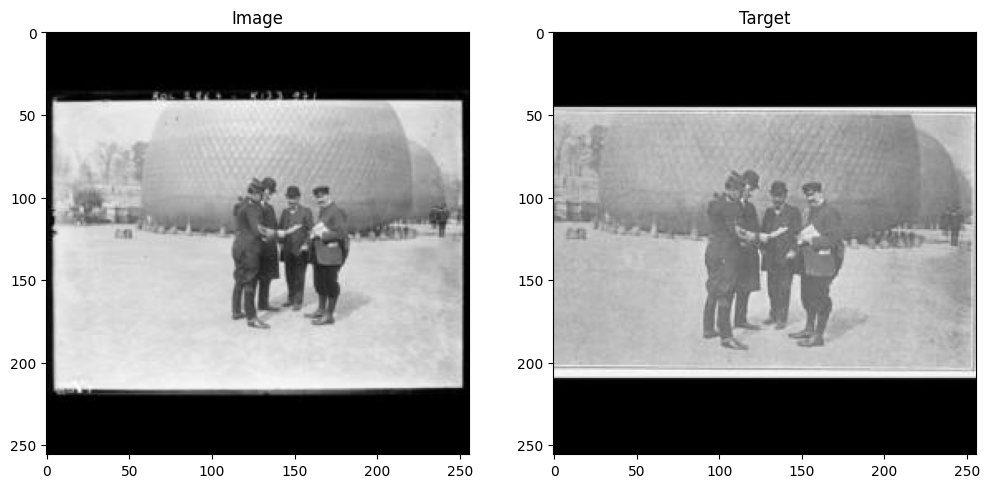

In [10]:
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)
DSC.show_data(test_loader, 1, use_context=True, is_test=True)

In [13]:
model = SimCLR(feature_size=128, use_context=True, context_weights=100.0)
model_state = Trainer().get_model("C:/Cours-Sorbonne/M1/Stage/src/params/model/model_simclr_RGW.pth")
model.load_state_dict(model_state)
history = Trainer().get_history("C:/Cours-Sorbonne/M1/Stage/src/params/model/history_simclr_RGW.txt")

In [14]:
top_k_pairs, original_images, augmented_images = SMY.match_images_with_simCLR(model, test_loader=test_loader, use_context=True, k=20, use_sift=False, is_test=True)

[INFO] Matching on cuda


100%|██████████| 7/7 [00:10<00:00,  1.55s/it]

[INFO] Top-1 Precision: 0.2777777777777778
[INFO] Top-5 Precision: 0.51010101010101
[INFO] Top-10 Precision: 0.6313131313131313
[INFO] Top-15 Precision: 0.6868686868686869
[INFO] Top-20 Precision: 0.7373737373737373


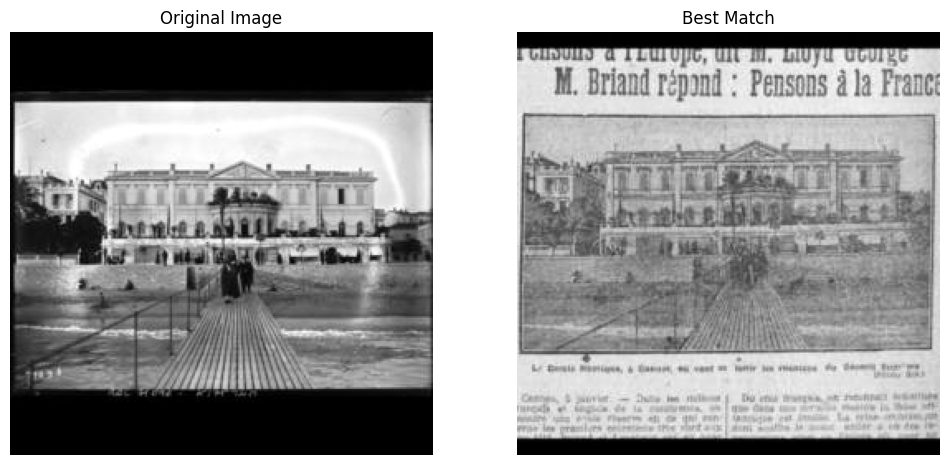

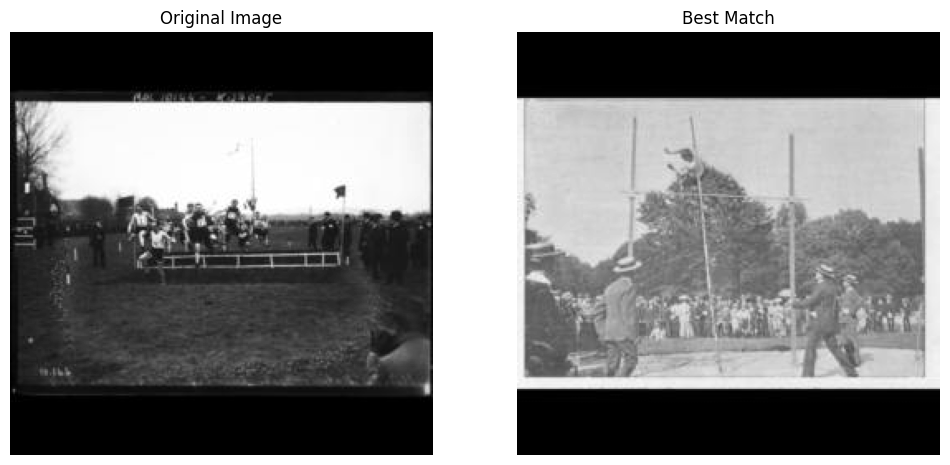

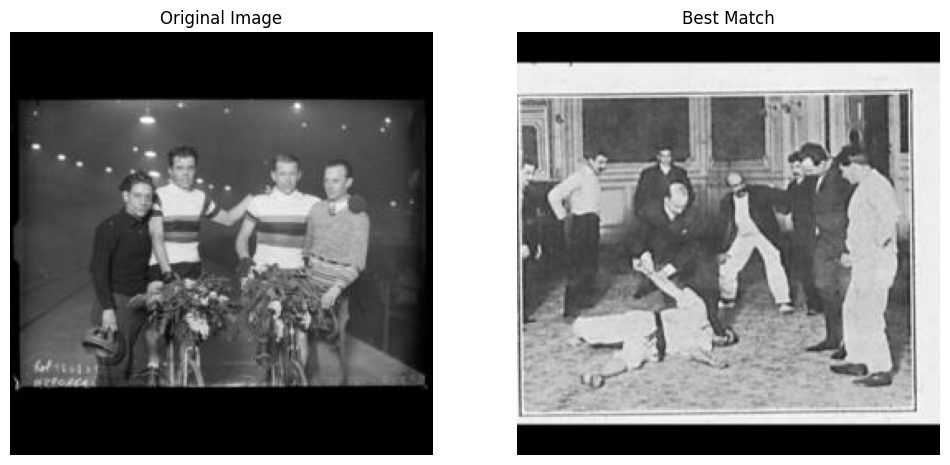

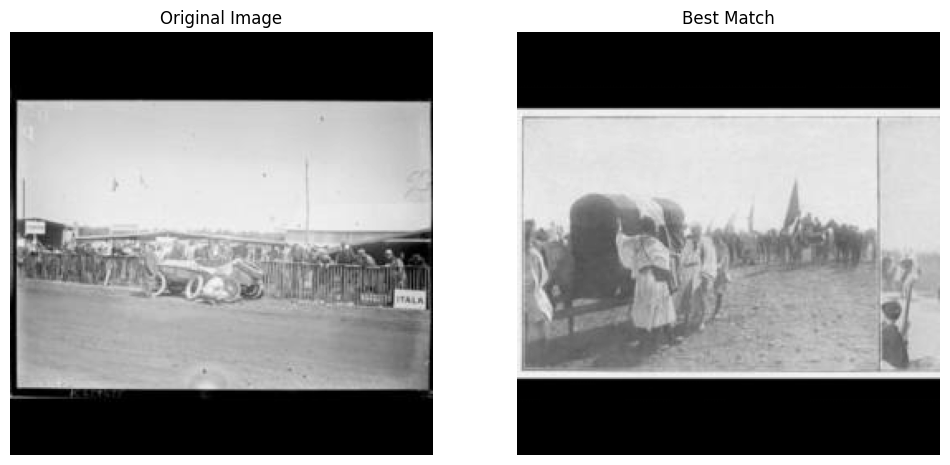

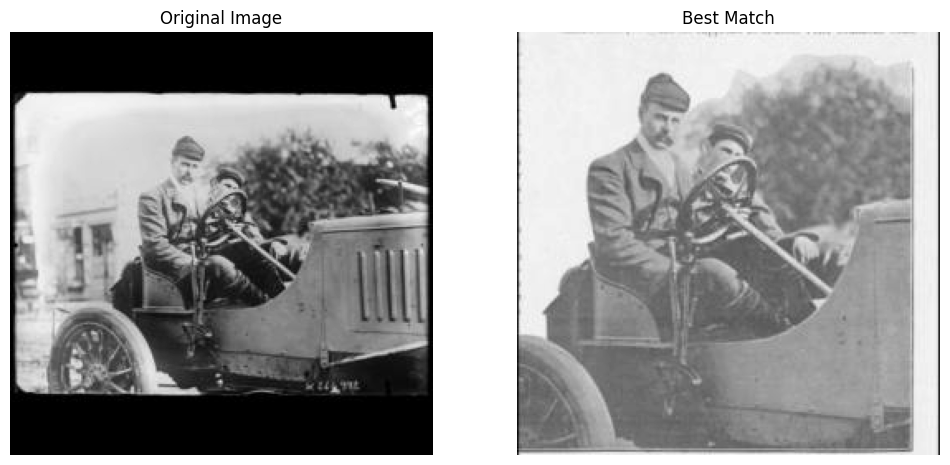

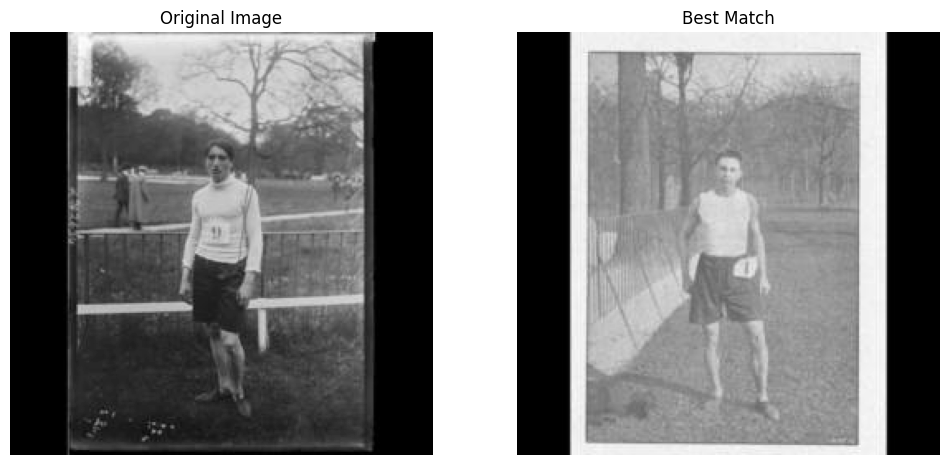

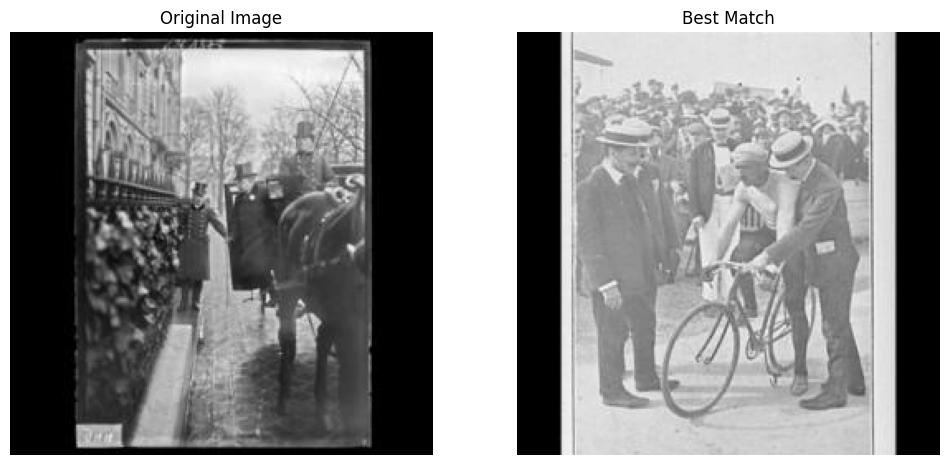

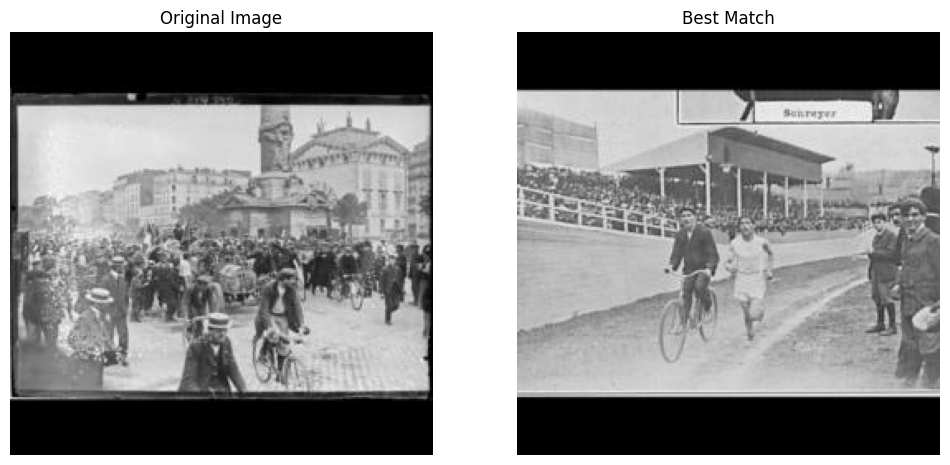

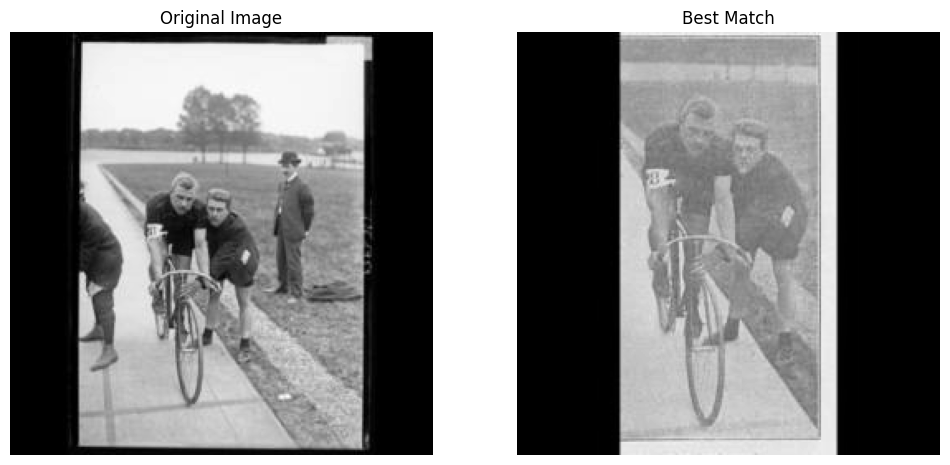

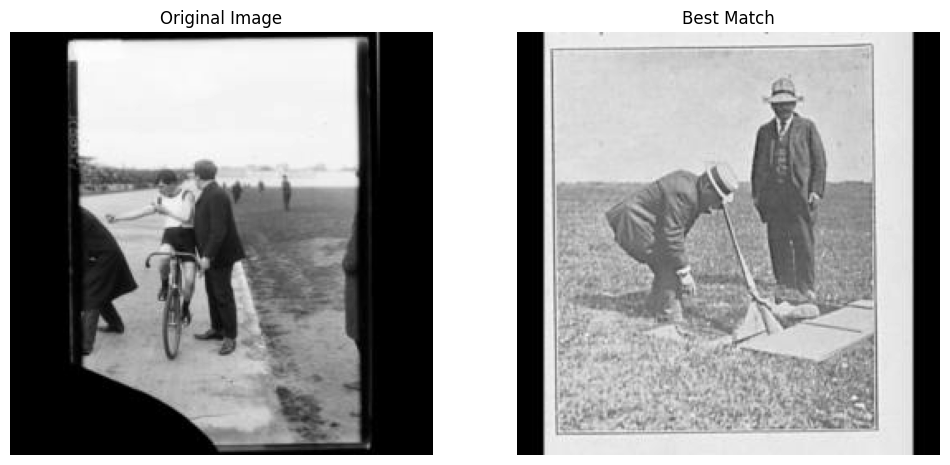

In [15]:
best_pairs = top_k_pairs[:,0]
PL.plot_best_pairs(best_pairs, original_images, augmented_images, max_images=10)